In [1]:
#Imports
import healpy as hp
from ligo.skymap.io import fits 
import numpy as np
import time


In [2]:
%matplotlib inline

In [3]:
def draw_circles(nside,vec_arr,rad,eps=0.8):
    """
    Takes input array of vectors, output pixels at edges of pointings
    eps should be <1, around 0.8 good for full skymaps
    """
        
    cov_pix = set()
    for n in range(len(vec_arr)): 
        temp_pix = hp.query_disc(nside,vec_arr[n],rad,nest=True)
        temp_pix_98 = hp.query_disc(nside,vec_arr[n],rad*eps,nest=True)
        
        cov_pix = (set(temp_pix) - set(temp_pix_98)) | cov_pix
         
    cov_pix = np.array(list(cov_pix))

    
    return cov_pix

In [4]:
class area:
   
    
    def __init__(self, m, rad, deg_fact=8, dil=1, nested=True, nside = None):
        """
        m is array with pixel probabilities
        rad input in degrees
        dilation optional argument, reduces distance between pointings to 
        prevent uncovered area at triple point in tessellation
        nest takes argument from metadata, True or False
        """
        # Make input variables locally accessible
        
        self.rad = rad
        
        self.m = m
        
        self.nested = nested 
        
        self.gap = np.sin(np.pi/3) * 2*self.rad * dil
        
        if nside is None: 
            self.nside = hp.npix2nside(len(m))
        else:
            self.nside = nside
        
        #Obtain pixels covering the 90% region
        #Sorts pixels based on probability, 
        #then takes all pixel until cumulative sum is >= 90%
        mflat = m.flatten()
        i = np.flipud(np.argsort(mflat))
        msort = mflat[i]
        mcum = np.cumsum(msort)            
        ind_to_90 = len(mcum[mcum <= 0.9*mcum[-1]])

        self.area_pix = i[:ind_to_90]
        self.max_pix  = i[0]

        x,y,z = hp.pix2vec(self.nside,self.area_pix,nest=nested)
        
        self.area_arr = np.concatenate((x.reshape(-1,1),
                                             y.reshape(-1,1),
                                             z.reshape(-1,1)), axis=1) 
        self.max_prob = self.area_arr[0] 
        
        
        #####################Compress 90% region pixels  ######################
        # reduce the number of pixels to search for by degradin resolution,
        # Maintain original resolution for m
        # reducing nside by a factor of 2 reduces npix by 75%
        # factor of 4 reduces to 6.25%, need this for comparable speed to previous test
        # Has diminishing returns under main routine, saves ~10 seconds between 8 and 16
        # saves only 4 sec between 16 and 32
        n = np.zeros(len(m))
        n[self.area_pix] = 1 / len(self.area_pix)
        
        self.nsideD = int(self.nside / deg_fact)
        self.mD = hp.pixelfunc.ud_grade(n,self.nsideD,order_in='NESTED',order_out='NESTED')
        
        #mD is degraded map just of 90% pixels, values are averaged in degrading,
        #so all pixels with non-zero result should be counted as in region
        
        j = np.flipud(np.argsort(self.mD))
        gradSort = self.mD[j]
        ind = len(gradSort[gradSort > 0])
        self.deg_pix = j[:ind]
        
       
    
    cov_arr = np.array([0,0])
    
    def find_covering(self, vec_arr, trim=True, use_degraded=True):
        """
        Returns array of pointings that survey part of the 90% region
        
        Trim: optional routine that removes pointings that do not survey any 
              unique pixels
        use_degraded: bool, if True then uses the pixels from the degraded map,
                      self.mD made at init, considerably speeds up computation
        """
        if use_degraded: 
            nside = self.nsideD
            areaPix = self.deg_pix
        else:
            nside = self.nside
            areaPix = self.area_pix
            
        cov_vecs = []
        cov_pix = []
        for vec in vec_arr: 
            
            surveyedPix = hp.query_disc(nside,vec,self.rad,inclusive=False,nest=self.nested)
            
            surv_area_pix = np.intersect1d(surveyedPix,areaPix,assume_unique=True)
            
            if len(surv_area_pix > 0): 
                cov_vecs.append(vec), cov_pix.append(surv_area_pix)
                
        cov_vecs = np.array(cov_vecs)    
        
        if trim:
            n = 0
            trim_ind = []
            skip_list = []
            while n < len(cov_pix):
                cum_pix = cov_pix[:n] + cov_pix[(n+1):]
                i = cov_pix[n]
                subset = False
                for m in range(len(cum_pix)):
                    if m in skip_list: continue
                    if len(i) == len(np.intersect1d(i,cum_pix[m],assume_unique=True)):
                        skip_list.append(n)
                        subset = True
                        break
                    
                if not subset: trim_ind.append(n)
                n+=1    
            self.cov_arr = cov_vecs[trim_ind] 
        else:
            self.cov_arr = cov_vecs
        
        return self.cov_arr

    

In [11]:
class gberg_comb:
    
    def __init__(self,nside,radius,dil=1):
        """
        Define vertices for goldberg polyhedron to generate comb tessellation
        """
        
        top_and_bottom = np.array([[0,0],[np.pi,(9/5)*np.pi]])
        ring = np.array([[((n%2)*2*np.arctan(1/2) + np.arctan(2)),
                          phi] for n,phi in zip(range(10),np.arange(0,2*np.pi,np.pi/5))])

        #distance between each vertex is arctan(2)
        vertices = np.concatenate((top_and_bottom,ring),axis=0)

        self.vertices = hp.ang2vec(vertices[:,0], vertices[:,1])
        #indices to triangle vertices in vect_vert
        self.tri_ind = [(0,n,(n+2 if n<10 else 2)) for n in range(2,12,2)] +\
                       [(1,n,(n+2 if n<11 else 3)) for n in range(3,12,2)] +\
                       [(n,(n+1 if n<11 else n+1-10),
                             (n+2 if n<10 else n+2-10)) for n in range(2,12,1)]
        
        self.radius = radius
        
        ##### Genereate 2D triangular comb to map to sphere ##################
        
        gap = np.sin(np.pi/3) * 2*self.radius * dil
        n = np.ceil(np.arctan(2) / gap).astype(int)
     
        diag_vect = np.array([0.5*np.arctan(2),((3**.5)/2)*np.arctan(2)])
        corner = np.array([-0.5*np.arctan(2),0])
        
        seed_arr = np.array([])
        for i in range(n+1):
            init_point = corner + i/n *np.array([[np.arctan(2),0]])
            for j in range(n-i+1):
                new_seed = j/n * diag_vect + init_point
            
                if len(seed_arr)==0:
                    seed_arr = new_seed
                else:
                    seed_arr = np.concatenate((seed_arr,new_seed),axis=0)
    
        self.seeds2D = seed_arr
        ######################################################################
        
    def bary_coords(self,p):
        """
        Takes input coordinate p as 2D tuple, converts to barycentric coordinates
        on the 2D triangle given by vertices (-0.5*atan(2),0),(0.5*atan(2),0),
        (0,sqrt(3)/2*atan(2))
        Chosen such that sidelength = atan(2), the given arclength between vertices
        """
        x,y = p
        # l3*sqrt(3)/2 = y
        l3 = y * (2. / ((3.**0.5)*np.arctan(2)))
        # l1 + l2 + l3 = 1
        # 0.5*np.arctan(2)*(l2 - l1) = x
        l2 = x/np.arctan(2) + 0.5*(1 - l3)
        l1 = 1 - l2 - l3
        return l1,l2,l3

    def slerp(self,p0,p1,t):
        """
        spherical linear interpolation routine, for use mapping from cartesian
        to spherical coordinates
        """
        assert abs(np.dot(p0,p0) - np.dot(p1,p1)) < 1e-7 #check magnitudes the same, 
                                                      #ie lie on same spherical hyperplane
                                                      
        ang0Cos = np.dot(p0,p1)/np.dot(p0,p0)
        ang0Sin = (1 - ang0Cos**2)**0.5
  
        ang0 = np.arctan2(ang0Sin,ang0Cos)
        l0 = np.sin((1-t)*ang0)
        l1 = np.sin(t    *ang0)
        return list([(l0*p0[i] + l1*p1[i])/ang0Sin for i in range(len(p0))])


    def mapCart2Sphere(self,p,s1,s2,s3):
        """
        Routine mapping cartesian to spherical coordinates, input is cartesian
        point p as tuple and three cartesian vectors to the indices of the 
        triangle to map to
        """
        
        l1,l2,l3 = self.bary_coords(p)
        if abs(l3-1) < 1e-10: return s3
        l2s = l2/(l1+l2)
        p12 = self.slerp(s1,s2,l2s)
        return self.slerp(p12,s3,l3)

    
        
    def map_comb(self,tri_inds,vertices = None):
        """
        cover the selected triangles on sphere with pointings
        """
        if vertices is None:
            vertices = self.vertices
            
        point_vecs = []
        for tri_ind in tri_inds: 
            ind1,ind2,ind3 = tri_ind
            
            for seed in self.seeds2D:
                
                vec = self.mapCart2Sphere(np.array(seed),vertices[ind1],
                                                         vertices[ind2],
                                                         vertices[ind3])
                point_vecs.append(vec)
                
        return  np.unique(np.array(point_vecs),axis=0)
            
        

    def make_sample(self, coord, res=0.5, itr=8):
        """
        constructs sample displacement vectors for translation testing, based
        on filling one sampling site with honeycomb tesselation
        Uses instance of comb class
        rad gives the radius of the site to sample, set to sample rad if none given
        res gives the spacing between sites in degrees
        
        assumes that can approximate polar coordinates as cartesian, returns 
        the cosine of angles for rotation as well as the unit vector axes
        """
        res = np.deg2rad(res)
        theta,phi = hp.vec2ang(coord)
        coord = np.concatenate((theta,phi))
        
        
        seed_arr = np.array([coord])
        seed_list = [[seed_arr[0][0],seed_arr[0][1]]]
        
        n = 0
        while n < itr: 
            
            n = n+1
            init_seed = [coord[0] + n*res*np.sin(0),
                         coord[1] + n*res*np.cos(0)]
            seed_list.append(init_seed)
            
            prevAngle = 0
            for j in range(6):
                angleSum = (2*np.pi/3) if j == 0 else (prevAngle + np.pi/3)
                prevAngle = angleSum
                
                for i in range(1,n+1,1):
                    
                    next_seed = [init_seed[0] + i*res*np.sin(angleSum),
                                 init_seed[1] + i*res*np.cos(angleSum)]
                    seed_list.append(next_seed)
                    
                    if i == n: init_seed = next_seed
        seed_arr = np.array(seed_list)           
        
        vec_arr = hp.ang2vec(seed_arr[:,0],seed_arr[:,1])
        cos_psi = np.array([np.dot(vec_arr[0],vec) for vec in vec_arr[1:]])
        
        axis_vec = [np.cross(vec_arr[0],vec) for vec in vec_arr[1:]]
        axis_vec = [vec / np.linalg.norm(vec) for vec in axis_vec]
        return cos_psi, axis_vec
         
    def rotate(self, vectors, r, cos_psi):     
       """
       Performs Rodrigues rotation on set of points in vectors, assumes that 
       input values are given under self.cos_psi, self.axis_vec
       vectors is set of points on which to perform rotation, cos_psi is the 
       given by the dot product of those unit vectors, r is the unit vector axis
       of rotation
       returns array of rotated vectors
       """
       vectors_rot = []
       for v in vectors: 
           
           rvcross = np.cross(r,v)
           rvdot   = np.dot(r,v)
           sin_psi = np.sin(np.arccos(cos_psi))
           
           vrot    =  (v*cos_psi) + (rvcross*sin_psi) + (r*rvdot*(1 - cos_psi))
           vectors_rot.append(vrot)
           
       return vectors_rot
      

Map:	data/design_bns_astro/204.fits

	Data loading time:	0.5982
	Initializing time:	0.7966
	Area size:		14302 pixels

	Time generating comb:	0.0591
	Time finding covArr:	0.0642
	Time rotating vertices:	0.0007

	Loop time:		4.4427

	Final optimizing time:	4.4451
	Minimum pointings:	4
	Improvement:		1 pointings
	Total elapsed time:	5.9644

[7232119 7232125 7232296 ... 7226270 7226269 7226257]

[0. 0. 0. ... 0. 0. 0.]


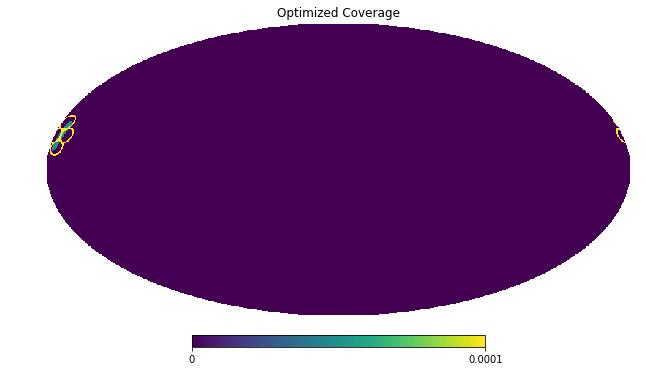

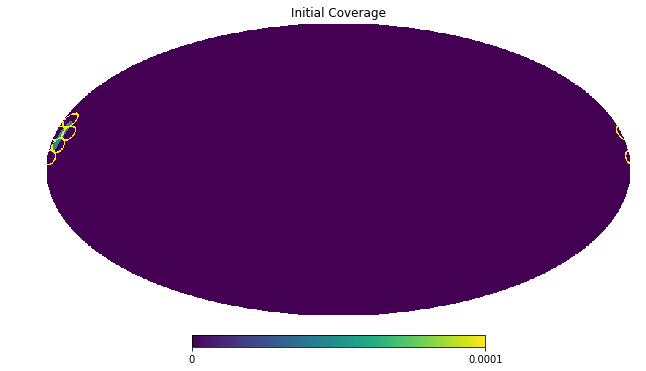

In [25]:

readTime = time.time()
# Inputs
dataset = 'design_bns_astro' # name of dataset ('design_bns_astro' or 'design_bbh_astro')
fov_diameter = 8 # FOV diameter in degrees

# Convert FOV to radius and radians
fov_diameter = np.deg2rad(fov_diameter)
fov_radius = fov_diameter / 2

# Open a new file to write results to
#data_file = open(dataset + '_pointings.dat', 'w')
#data_file.write('coinc_event_id\tpointings\n')

#Open sample file, tested on 100
i = 204

m, metadata = fits.read_sky_map('data/' + dataset + '/' + str(i) + '.fits', nest=None)  

print('Map:\tdata/' + dataset + '/' + str(i) + '.fits\n')
print('\tData loading time:\t%0.4f' % (time.time()-readTime))             
############################################################################

initTime = time.time()
region90 = area(m,fov_radius,dil=0.99,deg_fact=8)
comb     = gberg_comb(region90.nside,fov_radius)
print('\tInitializing time:\t%0.4f' % (time.time()-initTime))

print('\tArea size:\t\t%d pixels\n' %(len(region90.area_pix)))

stime = time.time()
pointings = comb.map_comb(comb.tri_ind)
print('\tTime generating comb:\t%0.4f' % (time.time()-stime))

stime = time.time()
covArr    = region90.find_covering(pointings)
print('\tTime finding covArr:\t%0.4f' % (time.time()-stime))

stime = time.time()
null = comb.rotate(comb.vertices,region90.max_prob,np.cos(np.pi/2))
print('\tTime rotating vertices:\t%0.4f\n' % (time.time()-stime))


init_score = len(covArr)


#New routine needs to rotate vertices to each angle, map new points, then
# rotate to each of the sites and record the number covering
# Faster for the routine to map new points to the comb than to 
# rotate all the given points, minimize number of points given to rotate

# Routine to test sample sites, picks angles at 10 deg increments from 0 - 60
# rotates between these angles about the max_prob pixel in the area
# At each of these positions, rotates between 224 sample sites in hexagonal
# arrangement, finds covering for each
# returns list with the best scores, index into cos_psi/axis_vec, and the 
# major angle value

ttime = time.time()

cos_psi_arr, axis_vec_arr = comb.make_sample(region90.max_prob,res=1.33,itr=3)

best_scores = []
best_points = []
psi2 = 0

stime = time.time()

vert = comb.rotate(comb.vertices,region90.max_prob,np.cos(psi2))

init_points = region90.find_covering(comb.map_comb(comb.tri_ind))
scoreList = [len(init_points)]
pointList = [init_points]
for cos_psi, axis_vec in zip(cos_psi_arr,axis_vec_arr):

    rotPoints = comb.rotate(vert,axis_vec,cos_psi)
    points = comb.map_comb(comb.tri_ind,vertices = rotPoints)
    trans_points = region90.find_covering(points)
    scoreList.append(len(trans_points)), pointList.append(trans_points)

bestscore = min(scoreList)
best_scores.append(bestscore), best_points.append(pointList[scoreList.index(bestscore)])
print('\tLoop time:\t\t%0.4f' % (time.time() - stime))   


final_best_score = min(best_scores)
index = best_scores.index(final_best_score)
final_pointings = best_points[index]
print('\n\tFinal optimizing time:\t%0.4f\n\tMinimum pointings:\t%d' % ((time.time() - ttime),final_best_score))
print('\tImprovement:\t\t%d pointings' % (init_score-final_best_score))
print('\tTotal elapsed time:\t%0.4f\n' % (time.time()-readTime))


# Debug routine, produces mollweide view of final array
init_pix = draw_circles(region90.nside,covArr,fov_radius)
opt_pix = draw_circles(region90.nside,final_pointings, fov_radius)     

n = np.zeros(len(m))
l = np.zeros(len(m))
n[region90.area_pix] = 0.00005
l[region90.area_pix] = 0.00005

l[init_pix] = 0.0001
n[opt_pix] = 0.0001

print(region90.area_pix)
print()
print(n)



hp.mollview(n,nest=True,title='Optimized Coverage')	
hp.mollview(l,nest=True,title='Initial Coverage')
#hp.cartview(testpix,nest=True)

# file = open("opt_pointings/" + dataset + '_' + str(i) + '_Comb_Pointings.txt','w+')
# file.write('\ndata/' + dataset + '/' + str(i) + '.fits Pointings\n\n' + str(final_pointings))
# file.close()
